## <font color='green'> Assignment 3</font>

In [39]:
# Loading required libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.svm import LinearSVR

from math import sqrt
import pandas as pd
import numpy as np


from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

### <font color='blue'> 1. Write a brief statement: Is it required to consider the repeating features in the model? (For example: precipitation_amt_mm and reanalysis_sat_precip_amt_mm. Similarly there are others). List which features you will choose in this model. Select the required columns in the dataframe and drop the others.</font>

In [40]:
assign_3 = pd.read_csv("C:/Users/mohad/Documents/USF/DSP/assignment_2/data_assignment_2.csv")
assign_3.drop('prec_amt_mm',axis=1,inplace=True)
# print(assign_3.columns)
assign_3.shape

(1409, 22)

In [41]:
c = assign_3.corr().abs()
sort = c.unstack() 
correlated_cols = sort.sort_values(kind="quicksort") 
correlated_cols = correlated_cols.dropna() 
correlated_cols[(correlated_cols.values > 0.9) & (correlated_cols.values <1)]

re_an_max_air_temp_k        re_an_tdtr_k                  0.920176
re_an_tdtr_k                re_an_max_air_temp_k          0.920176
re_an_specific_hd_g_per_kg  re_an_dew_point_temp_k        0.997015
re_an_dew_point_temp_k      re_an_specific_hd_g_per_kg    0.997015
dtype: float64

    When two attributes give information about the same thing then they are duplicates and these might trick our model in    terms of rule generation. As the two attributes have same data, the rules generated will be same thus, there wont be any use of having such duplicate columns

So looking at the variables, I am dropping the columns which have high corelation (0.9 >).
These variables are :

    re_an_max_air_temp_k - This is intercorelated with re_an_tdtr_k. Hence I am dropping this as re_an_tdtr_k is the difference between max and min temparature of the day
    
    
    re_an_dew_point_temp_k - This is corelated with  re_an_specific_hd_g_per_kg. This says that the pressure is highly dependent on temparature. Hence droppping the pressure
    

In [42]:
assign_3 = assign_3.drop(['re_an_max_air_temp_k','re_an_dew_point_temp_k'],axis=1)

### <font color='blue'>2. Preprocess the data</font>


    A) Encode the categorical features: Already created in assignment 2


In [43]:
# categoricalFeatureNames = ["city", 'year']

# #convert the attributes listed above to categorical form

# for var in categoricalFeatureNames:
#     assign_3[var] = assign_3[var].astype("category")
    
# X_assign_3_dummies = pd.get_dummies(X_train[['city','year']])

     B) Abbreviate the column names - Worked on it in assignment 1

In [44]:
# assign_3.columns = assign_3.columns.str.replace(r"reanalysis", "re_an")
# assign_3.columns = assign_3.columns.str.replace(r"humidity", "hd")
# assign_3.columns = assign_3.columns.str.replace(r"precipitation","prec")

      D) Handle NaNs - Filled with Mean in assignment 1

In [45]:
# assign_3 = assign_3.fillna(method='ffill')

     E) Convert percentage to value/100 (check which option gives better result, as-is or divided/100)

In [46]:
#Converting to just value did not improve the accuracy much. Just with percentage, I got a decent model

      F) Scale the vegetation features (ndvi*) as 0, 1 (0 <= 0.25 and 1 > 0.25) as it is in scale of 0 to 0.5. Retain as is or use other scaling based on how model performs.

In [47]:
#I found th scaling option to be better with slight improve in the model performance
veg_features = ['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw']
for i in veg_features:
    assign_3[i][assign_3[i] <= 0.25] = 0
    assign_3[i][assign_3[i] > 0.25] = 1
    assign_3[i] = assign_3[i].astype('category')

      C & G) Standardize the numerical features, Make an 80-20 train-test split

In [48]:
X_numeric = assign_3.drop(columns=['city', 'year','total_cases',
                                    'ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw'])
assign_3['year'] = assign_3.year.astype('category')
dummy_attributes = assign_3[['city', 'year',
                                    'ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw']]
X_dummies = pd.get_dummies(dummy_attributes)
X_data = pd.concat([X_numeric,X_dummies ],axis=1)
y_data = assign_3['total_cases']
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.20)

scaler = StandardScaler()
standardized_numeric_data = scaler.fit_transform(X_train[X_numeric.columns])
X_train_np = np.concatenate((standardized_numeric_data,np.array(X_train[X_dummies.columns])),axis=1)
standardized_numeric_data_test = scaler.transform(X_test[X_numeric.columns])
X_test_np = np.concatenate((standardized_numeric_data_test,np.array(X_test[X_dummies.columns])),axis=1)

### <font color='blue'>3.Build a Linear SVR regressor, train the model</font>

<font color='green'>      a. Evaluate your model based on applicable metrics. Show the metric(s) you chose and why you chose this(these) metrics. </font>
    
    I chose RMSE error (Root Mean Square Error). It is measure on how far from the regression line the data points are. THe RMSE error gives low weightage to points around the best fit line and high weightage to points farther from the line. It basically tells us how concentrated the data is arounf the line of best fit. The high error on train and low on test says that the model is under fitting and we can increase its complexity.
   

In [49]:
svr_lin = LinearSVR()
# With C as 1 and the l1 at 0 model is very naive and has high error.

svr_lin.fit(X_train_np,y_train)
y_train_predict = svr_lin.predict(X_train_np)
y_test_predict = svr_lin.predict(X_test_np)
train_errors= sqrt(mean_squared_error(y_train, y_train_predict))
test_errors = sqrt(mean_squared_error(y_test, y_test_predict))
print("The training error of the model is ", train_errors)
print("The testing error of the model is ", test_errors)

The training error of the model is  19.366097774934378
The testing error of the model is  11.788679348389529


In [50]:
svr_lin = LinearSVR(C=10, loss = 'epsilon_insensitive',epsilon=0.3)
# With a higher Slack value of 10 and L1 regularization set at 0.3, I got reduction in the test and traing error

svr_lin.fit(X_train_np,y_train)
y_train_predict = svr_lin.predict(X_train_np)
y_test_predict = svr_lin.predict(X_test_np)
train_errors= sqrt(mean_squared_error(y_train, y_train_predict))
test_errors = sqrt(mean_squared_error(y_test, y_test_predict))
print("The training error of the model is ", train_errors)
print("The testing error of the model is ", test_errors)


The training error of the model is  18.72445561689593
The testing error of the model is  11.291289770518974


<font color='green'>      b. List the hyper-parameters that can be tuned in Linear SVR. Explain the meaning of each hyper-parameter. Show the code along with comments on the parameter value chosen (use class presentation, discussion notes, some online reading) and why this value was chosen. Show the improvement you achieved in model accuracy. </font>
    
    
    The Linear SVR is similar to the Traditional SVR but it supports only linear kernel and is implemented in terms of liblinear rather than libsvm.

There are two main parameters to tune in the Linear version of SVR:
  1. The choice of penalties - The penality is represented by C. This is the amount of influence slack variables has on the function. Slack variable is the non-linear points which are tough to classify. Hence, we will ignore these points. The C is the way of saying how much to ignore.  With high C value the models puts penalities on the slack points and hence creates an over-complicated one.
  
  2. Loss functions- The Lasso (L1) loss function is the standard way of entering the value in Linear SVR. By setting loss as epsilon insensitive we are saying it to start with L1 regularization and with epsilon of 0.3 I got least error

<font color='green'>      c. Plot Learning curve and provide insights </font>


    From the learning curve we can see that the error in train and test samples has stabilized after 150 samples. But as this is a linear kernel, it was not able to reduce the error further and with increase in the sample size the model did not learn much

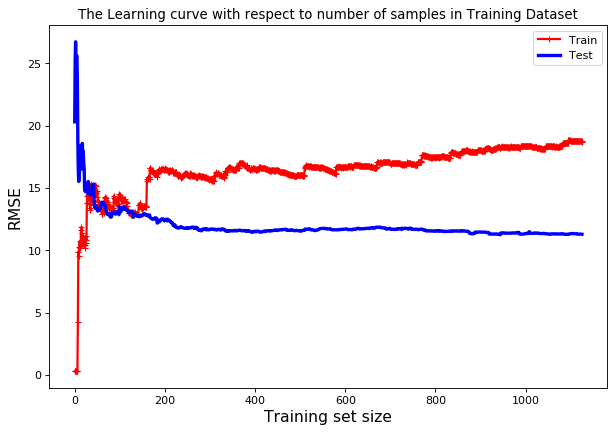

In [51]:
train_errors, test_errors = [], []
for m in range(1, len(X_train_np)):
    svr_lin.fit(X_train_np[:m], y_train[:m])
    y_train_predict = svr_lin.predict(X_train_np[:m])
    y_test_predict = svr_lin.predict(X_test_np)
    train_errors.append(sqrt(mean_squared_error(y_train[:m], y_train_predict)))
    test_errors.append(sqrt(mean_squared_error(y_test, y_test_predict)))
    
figure(num=None, figsize=(9,6), dpi=80, facecolor='w', edgecolor='k')    
plt.plot(train_errors, "r+-", linewidth=2, label = "Train")
plt.plot(test_errors, "b-", linewidth=3, label = "Test")
plt.title("The Learning curve with respect to number of samples in Training Dataset")
plt.legend(loc="upper right", fontsize=14) 
plt.xlabel("Training set size", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.legend()

### <font color='blue'>4. Build a SVR model with Linear Kernel, train the model

<font color='green'>    a. Evaluate your model based on applicable metrics. Show the metric(s) you chose and why you chose this(these) metrics.
    
      I chose RMSE error (Root Mean Square Error). It is measure on how far from the regression line the data points are. THe RMSE error gives low weightage to points around the best fit line and high weightage to points farther from the line. It basically tells us how concentrated the data is arounf the line of best fit
    
<font color='green'>      b. List the hyper-parameters that can be tuned in SVR model with Linear Kernel. Show the code along with comments on the parameter value chosen (use class presentation, discussion notes, some online reading) and why this value was chosen. Show the improvement you achieved in model accuracy. 
  
  
      There are mainly Three parameters that can be tweaked to improve the performance of model
    
    C- Regularization Parameter - The Cost function on the slack variable. This controls the train error and test error relationship. To have a highly fitted model C value should be high

    gamma- The kernel co-efficient for Non-linear functions.  The degree to which we can use the kernel, it is used to set the amount of N dimensions we can throw data and a complexity manager for kernel


    Kernel - The type of Kernel for creating the hyperplane. This is the kernel matrix or kernel trick. There are different kernels A linear kernel throws the data in N dimensions and plots a linear curve, The Polynomial kernel increases the complexity and plots a curved hyperplane, Radial and hyperbolic ca learn any complex patterns.

In [52]:
lin_svr = SVR(kernel = 'linear')
lin_svr.fit(X_train_np,y_train)
y_train_predict = lin_svr.predict(X_train_np)
y_test_predict = lin_svr.predict(X_test_np)
train_errors= sqrt(mean_squared_error(y_train, y_train_predict))
test_errors = sqrt(mean_squared_error(y_test, y_test_predict))
print("The training error of the model is ", train_errors)
print("The testing error of the model is ", test_errors)

The training error of the model is  19.361016400519453
The testing error of the model is  11.797820513660284


In [53]:
lin_svr = SVR(C=100,kernel = 'linear',epsilon=0.3,coef0=0.1,gamma='auto')
lin_svr.fit(X_train_np,y_train)
y_train_predict = lin_svr.predict(X_train_np)
y_test_predict = lin_svr.predict(X_test_np)
train_errors= sqrt(mean_squared_error(y_train, y_train_predict))
test_errors = sqrt(mean_squared_error(y_test, y_test_predict))
print("The training error of the model is ", train_errors)
print("The testing error of the model is ", test_errors)

The training error of the model is  18.62038998562231
The testing error of the model is  11.290467427537049


<font color='green'> c. Plot Learning curve and provide insights
    
    THe Learning curve of Linear SVM with kernel is similar to the linear SVR, as these two are build from the same concepts. It is expected to have same output. The only difference I noticed is the time taken to perform training. The Linear SVR took very less time when comoared to the SVR with Kernel. Apart from it the information is same as above. Stabilizing after 150 samples

In [ ]:
train_errors, test_errors = [], []
for m in range(1, len(X_train_np)):
    lin_svr.fit(X_train_np[:m], y_train[:m])
    y_train_predict = lin_svr.predict(X_train_np[:m])
    y_test_predict = lin_svr.predict(X_test_np)
    train_errors.append(sqrt(mean_squared_error(y_train[:m], y_train_predict)))
    test_errors.append(sqrt(mean_squared_error(y_test, y_test_predict)))
    
figure(num=None, figsize=(9, 6), dpi=80, facecolor='w', edgecolor='k')    
plt.plot(train_errors, "r+-", linewidth=2, label = "Train")
plt.plot(test_errors, "b-", linewidth=3, label = "Test")
plt.title("The Learning curve with respect to number of samples in Training Dataset")
plt.legend(loc="upper right", fontsize=14) 
plt.xlabel("Training set size", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.legend()

### <font color='blue'> 5. Create a submission file which has predictions for both cities in the submission format </font>

In [126]:
test_df = pd.read_csv("C:/Users/mohad/Documents/USF/DSP/assignment_2/dengue_features_test.csv")
test_df.columns = test_df.columns.str.replace(r"reanalysis", "re_an")
test_df.columns = test_df.columns.str.replace(r"humidity", "hd")
test_df.columns = test_df.columns.str.replace(r"precipitation","prec")
test_df = test_df.fillna(method='ffill')

veg_features = ['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw']
for i in veg_features:
    test_df[i][test_df[i] <= 0.25] = 0
    test_df[i][test_df[i] > 0.25] = 1
    test_df[i] = test_df[i].astype('category')

In [127]:
X_test_numeric = test_df.drop(columns=['city', 'year',
                                    'ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw','week_start_date','weekofyear'])
test_df['year'] = test_df.year.astype('category')
dummy_attributes = test_df[['city', 'year',
                                    'ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw']]
# X_test_dummies = pd.get_dummies(dummy_attributes)
X_test_dummies = dummy_attributes.reindex(columns = X_dummies.columns, fill_value=0)

test_df_standardized = scaler.transform(X_test_numeric)
test_df_np = np.concatenate((test_df_standardized,np.array(X_test_dummies)),axis=1)

In [129]:
test_y_predict = lin_svr.predict(test_df_np)
submission_df= test_df[["city", "year","weekofyear"]]
submission_df["total_cases"] = test_y_predict
submission_df.to_csv("submission_aditya_2.csv",index=False)

### <font color='blue'> 7. Compare the Model Evaluation metric of SGD (Assignment 2), Linear SVR and SVR with Linear Kernel and state which model performed better along with reason why you consider so. </font>

#####  I got better performance using Stocastic Gradient. 

On SGD, The error is 18.14 on train and 17.38 on test dataset

Using Linear SVR the error is 17.08 on train and 19.63 on test

Using just SVR the error is 17.021 on train and on 19.578 test